# K-means Clustering and Economic Regime Classifier 
### Ian Alexei Zelaya 


## Framing the Problem

**Redaction on progress**

## Import and Data Preprocessing

The data used in this proyect is extracted from the OECD, the Federal Reserve Economic Data (FRED) and sqool.com.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
import datetime
from scipy.stats import mode
import pickle
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 5000)

,OECD CLI,3-M OECD CLI,3-M Unemploy rate,12-M Unemploy rate
1956-03-01,1.207512,-0.780813,-0.498738,-0.760412
1956-04-01,0.979529,-1.081266,-0.498738,-0.677389
1956-05-01,0.756809,-1.256445,-0.039051,-0.345300
1956-06-01,0.549296,-1.277710,-0.039051,-0.594367
1956-07-01,0.369678,-1.180645,0.573866,-0.013211


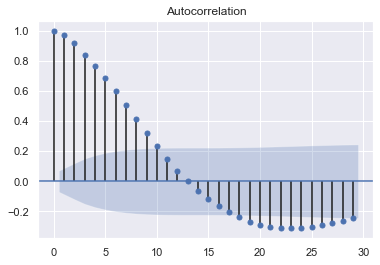

In [3]:
dirct = r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset'

class data_preprocessing: 
    def data_input(self, filename, featurename, existing_dataset=False, change=False, change_3=False, change_12=False, change_50=False, 
                   moving_average=False, diff=False, multiple=False, delimiter=',', start_date=False, end_date=False):
        """Transformation of a dataset with first column as date. Time series adjusted to begin from 1956, with 3-
        12- and 50-month changes as new columns. Input may be single or multiple variable datasets
        
        Params:
        change and moving_average accepts values as lists. Example: change([12]) for the change of 12 periods"""

        if multiple is True:
            data = pd.read_csv(r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset\{}'.format(filename), 
                               delimiter=delimiter, index_col=0)
            data.columns.values[0] = featurename
            differencing = data.pct_change() if diff is True else None
            for column in data: 
                # Adding the change in a period of months as new columns of the dataset
                if change is not False:
                    for m in change:
                        data['{}-M {}'.format(m, column)] = data[column] - data[column].shift(m) 
                    
                if moving_average is not False:
                    for ma in moving_average:
                        data['{}-MA {}'.format(ma, column)] = data[column].rolling(ma).mean()

                # Replace original data with differencing      
                if differencing is not None:
                    data.iloc[:, :differencing.shape[1]] = differencing
                    
            # Slicing dataset with custom start and end dates
            if start_date is not False:
                data = data.loc['{}'.format(start_date):'{}'.format(end_date)]
            else:
                data = data.loc['1956':'2020-06-01']
                
            # Adding new columns into an existing dataset if true
            if existing_dataset is not False:
                data = pd.concat([existing_dataset, data], axis=1, sort=True)
                return data
            else:
                return data

        else:
            data = pd.read_csv(r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset\{}'.format(filename), 
                               delimiter=delimiter, index_col=0)
            data.columns.values[0] = featurename
            differencing = data.pct_change() if diff is True else None

            # Adding the change in a period of months as new columns of the dataset
            if change is not False:
                for m in change:
                    data['{}-M {}'.format(m, featurename)] = data.iloc[:,0] - data.iloc[:,0].shift(m)
                    
            if moving_average is not False:
                for ma in moving_average:
                    data['{}-MA {}'.format(ma, column)] = data[column].rolling(ma).mean()

            # Replace original data with differencing  
            if differencing is not None:
                data[featurename] = differencing
                
            # Slicing dataset with custom start and end dates
            if start_date is not False:
                data = data.loc['{}'.format(start_date):'{}'.format(end_date)]
            else:
                data = data.loc['1956':'2020-06-01']
                
            # Adding new columns into an existing dataset if true
            if existing_dataset is not False:
                data = pd.concat([existing_dataset, data], axis=1, sort=True)
                return data
            else:
                return data


    def feature_scaling(self, data):
        """Feature scaling using Standard Scaler"""

        standard = StandardScaler()
        scaled = standard.fit(data)
        scaled = scaled.transform(data)
        scaled = pd.DataFrame(scaled)
        scaled.columns = data.columns
        scaled.index = data.index
        return scaled

    
data1 = data_preprocessing()
OECD = data1.data_input('OECD_CLI.csv', 'OECD CLI', delimiter=';', change=[3])
plot_acf(OECD['OECD CLI'])

data2 = data_preprocessing()
unemploy_rate = data2.data_input('UNRATE.csv', 'Unemploy rate', OECD, change=[3, 12])


X = data_preprocessing()
X_scaled = X.feature_scaling(unemploy_rate)
X_scaled = X_scaled.drop(columns=['Unemploy rate'])


## Shift values to adjust to the time-lag that takes for the OECD and Employment Situation to publish data from previous  
## months. Normally, the OECD and civilian unemployment rates publishes the data of a month mid the next month
## (Ex. Data from January gets published around February 15). Due to this lag, data of a month was not available in the same 
## month. For this indicator to be of value in a real-world scenario, a lag of two months has been made. Once used in a real-world
## scenario, the indicator can be even more precise as it will indicate the stage of month the same day the data has been published.
X_scaled = X_scaled.shift(2).dropna()
display(X_scaled.head())


## Data Exploration

From the many variables utilized to forecast the different stages of the business cycle, most proved to fail using clustering analysis. This may be for many reasons, but one of the important factors is that the business cycle works on turning points, which standard unsupervised learning algorithms may not consider when clustering the data. 

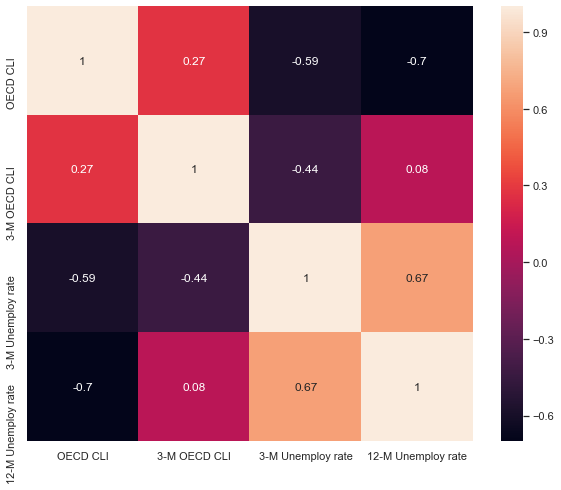

OECD CLI:


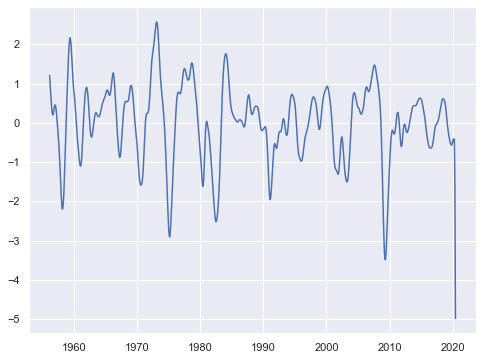

3-M OECD CLI:


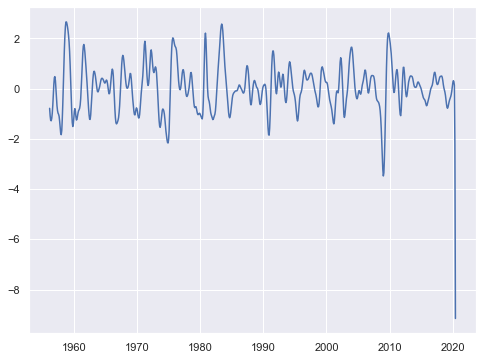

3-M Unemploy rate:


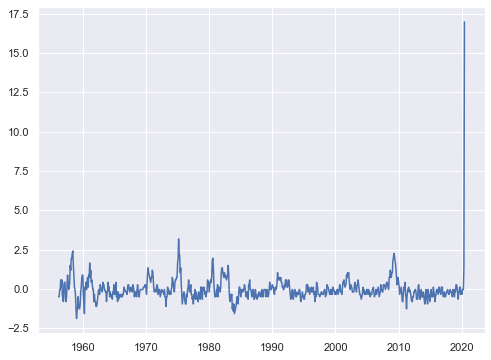

12-M Unemploy rate:


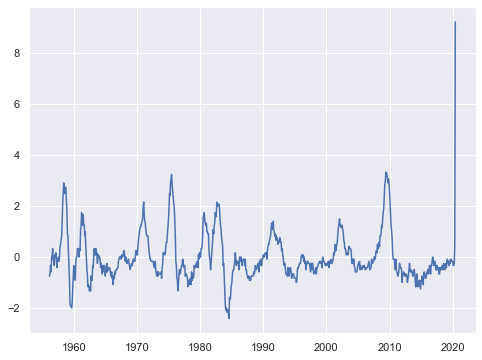

In [899]:
## Create a copy dataframe for plotting 
X_plot = X_scaled.copy()

## Plot correlations between feature variables
correlations = X_plot.corr().round(2)
plt.figure(figsize=(10, 8))
pt = sns.heatmap(correlations, annot=True)
pt.set_xlim(0, X_plot.shape[1])
pt.set_ylim(X_plot.shape[1], 0)
plt.show()

## Plot variables through time 
X_plot['Date'] = X_plot.index
X_plot['Date'] = X_plot['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

for i in X_plot.columns[:-1]:
    print(i + ':')
    plt.figure(figsize=(8,6))
    plt.plot(X_plot['Date'], X_plot[i])
    plt.show()


## Data Clustering with K-Means

In [339]:
## Feed the K-means algorithm with 5 clusters as a parameter to include the current severe economic downturn.
## This is important as severe economic downturns are historically cyclical (last time in 1932 for the U.S.)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaled)
print(kmeans.labels_)
X_labeled = X_scaled.copy()
X_labeled['Labels'] = kmeans.labels_
print(X_labeled[X_labeled['Labels']==4])


[0 0 4 4 4 4 4 4 0 0 0 0 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 0
 0 0 0 0 0 0 0 0 4 4 0 0 0 4 4 4 4 4 4 4 4 4 1 1 3 3 3 3 3 3 3 3 0 0 0 0 0
 0 4 4 4 4 4 4 4 4 0 4 4 0 0 4 0 4 0 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3
 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4
 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 3 3
 3 3 3 3 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4
 4 4 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0
 0 0 0 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 0 4 4 4 4 4 

In [25]:
# Save pandas dataframe as a .csv file 
X_labeled.to_csv('X_labeled.csv')
X_labeled = pd.read_csv('X_labeled.csv', index_col=0)

# Save the weights of the kmeans model as .sav file
pickle.dump(kmeans, open('Kmeans_weights.sav', 'wb'))

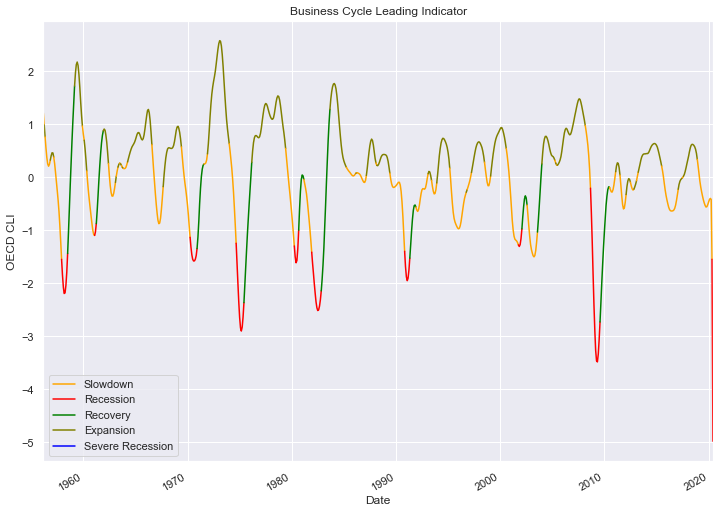

In [362]:
## Convert labels to colors
label2color = {
    4: 'orange',
    1: 'red',
    3: 'green',
    0: 'olive',
    2: 'blue',
}

X_plot = X_labeled.copy()
X_plot['color'] = X_plot['Labels'].apply(lambda label: label2color[label])
X_plot.index = pd.to_datetime(X_plot.index)

## Create plot
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)
        
        Returns: the element, the starting and the ending index of the repeated element sequence
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

## Plot OECD CLI with aggregated sliced dates according to their label of stage in the business cycle and color 
for color, start, end in gen_repeating(X_plot['color']):
    if start > 0: # make sure lines connect
        start -= 0
    idx = X_plot.index[start:end+2]
    X_plot.loc[idx, 'OECD CLI'].plot(ax=ax, color=color, label='', figsize=(12,9))

    
handles, labels = ax.get_legend_handles_labels()
    
## Create custom artists
o_line = plt.Line2D((0,1),(0,0), color='orange')
r_line = plt.Line2D((0,1),(0,0), color='red')
g_line = plt.Line2D((0,1),(0,0), color='green')
y_line = plt.Line2D((0,1),(0,0), color='olive')
b_line = plt.Line2D((0,1),(0,0), color='blue')

## Create legend from custom artist/label lists
ax.legend(
    handles + [o_line, r_line, g_line, y_line, b_line],
    labels + [
        'Slowdown',
        'Recession',
        'Recovery',
        'Expansion',
        'Severe Recession'
    ],
    loc='best',
)

## Display plot
plt.title('Business Cycle Leading Indicator')
plt.ylabel('OECD CLI')
plt.xlabel('Date')
plt.show()

As you can see, K-means has classified the stages of the business cycle successfully and serves as a leading indicator. As a continuation for this proyect, Neural Networks and XGBoosting will be trained using the labels of the K-Means and additional features. The objective of the second part of this project will be to predict whether the prices of stocks from a particular industry (Ex. Consumer Durables) will have positive or negative returns and their magnitude. 

**Further details about the analysis and strategy will be documented once the project is concluded**

## Continuation of the project in progress:

## Preparing Dataset for Neural Network

Dataset with Y-variables. The Y-variables for this proyect will be the monthly changes in industries of companies
in the the stock market 

In [403]:
# Import libraries for the neural network
import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.graphics.tsaplots import plot_acf
import os

# One-hot encoding for column 'Labels'
# labels_reshaped = X_labeled['Labels'].copy()
# labels_reshaped = tf.keras.utils.to_categorical(labels_reshaped, num_classes=5)

# bs_stages = pd.DataFrame(labels_reshaped, 
#                          columns=['Expansion', 'Recesion', 'Depression', 'Recovery', 'Slowdown'], 
#                          index=X_labeled.index.copy())

# # Additional column with lagging values of the column 'labels'
# bs_stages_lagged = bs_stages.rename(columns={'Expansion': 'Expansion Lag', 
#                                              'Recesion': 'Recession Lag', 
#                                              'Depression':'Depression Lag', 
#                                              'Recovery': 'Recovery Lag', 
#                                              'Slowdown': 'Slowdown Lag'}).shift(1)



## Import new features for the X dataset of the neural network
data3 = data_preprocessing()
DJI = data3.data_input('DJI.csv', 'DJI', diff=True, multiple=True, delimiter=';')


def macro_data(filename, new_file, save=True):
    directory = r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset\us'
    for i in os.listdir(directory):
        if i == filename:
            data = pd.read_csv(directory + '/' + filename)
            data_sliced = data[['<DATE>', '<OPEN>']]
            data_sliced = data_sliced.rename(columns={'<DATE>': 'Date', '<OPEN>': '{}'.format(new_file[:-4])})
            data_sliced['Date'] = pd.to_datetime(data_sliced['Date'], format='%Y%m%d')
            if save is True:
                data_sliced.to_csv(directory[:-2] + new_file, index=False)
            return data_sliced

# Variables extracted from the macro_data file

# Initial Claims
init_claims = macro_data('injcus.m.txt', 'InitClaims.csv')
data4 = data_preprocessing()
init_claims = data4.data_input('InitClaims.csv', 'InitClaims', start_date='1986', end_date='2021')
init_claims.index = pd.to_datetime(init_claims.index)
init_claims = init_claims.resample('W').ffill().shift(1).dropna()
print(init_claims.head())

# The rest of the variables downloaded individually

# VIX Index 
vxo = pd.read_csv(dirct + '/'+ 'vxo.csv', index_col = 0, delimiter = ',') 
vxo.index = pd.to_datetime(vxo.index.copy())
vxo.to_csv(dirct + '/' + 'vxo.csv')
data5 = data_preprocessing()
vxo = data5.data_input('vxo.csv', 'VXO', delimiter=',', start_date='1986', end_date='2021')

print(vxo.head())


print(init_claims.shape)


X_NN_scaled = data3.feature_scaling(DJI)
X_NN_scaled = X_NN_scaled.shift(1).dropna()


# In the X dataset, add columns with values from previous months (3 and 12 month lag) of the column 'Labels' and drop rows with 
# nan values due to the new columns. The objective is to help the neural network to learn if a label in month 't' is new or
# a continuation of a sequence of the label.
X_NN = X_labeled.copy()
#X_NN = X_NN.join(bs_stages)
#X_NN = X_NN.join(bs_stages_lagged)
X_NN = pd.concat([X_NN, X_NN_scaled], axis=1, sort=True)
X_NN = X_NN.drop(columns=['OECD CLI', 'DJI'])
X_NN = X_NN.dropna()

X_test2 = X_NN[-12:]
X_NN = X_NN[:-12]


# Converting positive monthly returns into "1" and negative monthly return into "0" for classifier NN
def pos_neg_converter(Y):
    row_counter = []
    for i in Y.columns:
        row_counter.clear()
        for j in Y[i]:
            row_counter.append(j)
            if j > 0:
                Y[i][len(row_counter)-1] = 1
            else:
                Y[i][len(row_counter)-1] = 0
    return Y 

#Importing DJI as Y dataset
data4 = data_preprocessing()
Y = data4.data_input('DJI.csv', 'DJI', diff=True, multiple=True, delimiter=';')
Y.index = pd.to_datetime(Y.index)
Y = Y.resample('W').ffill()
Y = pos_neg_converter(Y)
Y = Y.drop(columns=['DJI Volume'])
Y = Y.iloc[2:,:]
display(X_NN.head())
display(X_NN.tail())
display(Y.head())
display(Y.tail())
Y = tf.keras.utils.to_categorical(Y, num_classes=2)
Y_test2 = Y[-12:]
Y = Y[:-12]






            InitClaims
Date                  
1986-01-12       362.0
1986-01-19       397.0
1986-01-26       364.0
1986-02-02       344.0
1986-02-09       364.0
              VXO
Date             
1986-03-03  17.99
1986-03-10  18.91
1986-03-17  18.15
1986-03-24  17.36
1986-03-31  20.61
(1799, 1)


,3-M OECD CLI,3-M Unemploy rate,12-M Unemploy rate,Labels,DJI Volume
1956-03-01,-0.780813,-0.498738,-0.760412,0.0,-0.491118
1956-04-01,-1.081266,-0.498738,-0.677389,0.0,-0.216468
1956-05-01,-1.256445,-0.039051,-0.345300,4.0,1.277116
1956-06-01,-1.277710,-0.039051,-0.594367,4.0,-0.622207
1956-07-01,-1.180645,0.573866,-0.013211,4.0,-0.215054


,3-M OECD CLI,3-M Unemploy rate,12-M Unemploy rate,Labels,DJI Volume
2019-02-01,-0.745227,0.267408,-0.179255,4.0,0.431841
2019-03-01,-0.778599,0.267408,-0.096233,4.0,-0.668029
2019-04-01,-0.728780,0.114179,-0.262278,4.0,-1.286074
2019-05-01,-0.622008,-0.192280,-0.179255,4.0,0.987702
2019-06-01,-0.519924,-0.651967,-0.345300,4.0,-0.751929


,DJI
Date,
1956-01-15,1.0
1956-01-22,1.0
1956-01-29,1.0
1956-02-05,0.0
1956-02-12,0.0


,DJI
Date,
2020-05-10,1.0
2020-05-17,1.0
2020-05-24,1.0
2020-05-31,1.0
2020-06-07,1.0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_NN, Y, test_size=0.1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [ ]:
## Construction of the neural network structure and parameters
input_dim = X_NN.shape[1]
output_dim = 2

def defining_network():
    model = Sequential()
    model.add(Dense(12, input_dim=input_dim, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=75, batch_size=20, validation_data=(X_test,Y_test))
    
    return history, model
    
history, model = defining_network()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [278]:
y_pred = model.predict(X_test2)
y_pred = y_pred.round(3)

y_preds = list()
for i in range(len(y_pred)):
    y_preds.append(np.argmax(y_pred[i]))
    
y_preds = tf.keras.utils.to_categorical(y_preds, num_classes=2)

a = accuracy_score(Y_test2, y_preds)
print('Accuracy score on test set:')
print(a.round(3))


Accuracy score on test set:
0.5
